# DECISION TREES AND MODEL SELECTION

In [121]:
%matplotlib inline
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd

import seaborn as sns
sns.set_style("whitegrid")

from sklearn import set_config
set_config(transform_output = "pandas")

## decision tree

A **decision tree** model is a flowchart-like structure in which each **internal node** represents a test on a feature, each **branch** represents a possible outcome of the test and each **leaf node** represents a target (probability distribution). The paths from root (top) to leaf (bottom) represent prediction rules. 

Decision trees can be used for both classification and regression tasks, but here we will restrict the description to classification trees. Here is an example of a decision tree:

<br/>
<center>
<img src="https://github.com/sdgroeve/Machine_Learning_course_UGent_D012554_data/raw/master/notebooks/6_ensemble_learning/decisiontree.png"/>
</center>
<br/>
<br/>

The first test is performed in the **root node** (top node) and checks if feature `X[9]` has a value smaller than or equal to -0.5350. If it has, then we follow the left branch in the flowchart, if it hasn't we follow the right branch. This process is repeated until we reach a leaf node from which we obtain predicted class probabilities. 

The decision tree is built in a **top-down** fashion where the main question is how to choose which feature to split at each node? The answer is to find the feature that best splits the target class into the purest possible children nodes. This **measure of purity** is typically computed as the opposite of the **entropy** (which is a measure of impurity) of the class label probabilities in the data set. 

The idea behind classification decision tree construction is to assign an **entropy value to a set of data label probabilities** and use this entropy to find the **best split** at each node in the decision tree. Suppose we have a data set with 100 samples of which 20 belong to class 1 and 80 belong to class 2. For this data set, the probability $p_1$ that a data point belongs to class 1 is 0.2, the probability $p_2$ that a data point belongs to class 2 is 0.8. 

The entropy $H$ of these two class label probabilities is computed as

$$H(p_1,p_2) = -p_1 log_2(p_1) -p_2 log_2(p_2).$$ 

More general the entropy of any number of probabilities is computed as

$$H(p_i) = -\sum_i p_i log_2(p_i),$$

where $i$ ranges over the class probabilities. Let's compute the entropy for the probability of the classes in our data set:

In [122]:
from scipy.stats import entropy

print(entropy([.2,.8],base=2))

0.7219280948873623


Now suppose our data set contains only one sample for class 1 and 99 for class 2:

In [123]:
print(entropy([.01,.99],base=2))

0.08079313589591118


The entropy for this data set is much lower. To maximize the entropy of a data set we have to create one with an equal number of samples in class 1 and class 2:

In [124]:
print(entropy([.5,.5],base=2))

1.0


In this case, the uncertainty about the classes is maximal. 

The **binary entropy function** for two classes looks like this:

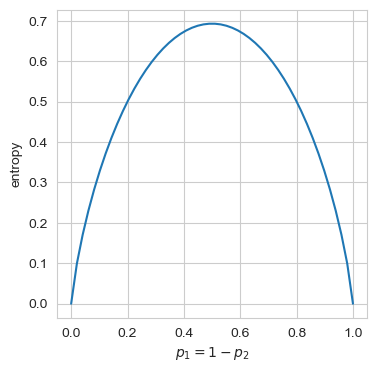

In [125]:
plt.figure(figsize=(4,4))
pvals = np.linspace(0, 1)        
plt.plot(pvals, [entropy([p,1-p]) for p in pvals])
plt.xlabel(r'$p_1=1-p_2$')
plt.ylabel('entropy')
plt.show()

A decision tree is constructed by **recursively splitting** (partitioning) a data set $D$. For each split the learning algorithm finds the feature that *best* partitioned the data set. To find this feature we can use several criteria, one of them is called **information gain**.

Information gain is the difference between the current entropy of a system and the entropy measured after a feature and test is chosen. If $D$ is a set of samples and $x$ is a possible feature that partitions $D$ in subsets $D_v$, then:

<br>
$$G(D,x) = \text{Entropy}(D) - \sum\frac{|D_v|}{|D|} \text{Entropy}(D_v).$$
<br>

The **decision tree learning algorithm** computes the information gain for each feature and test and selects the feature and test with the largest gain in information. This way, it searches the "tree space" according to a greedy strategy, i.e. not all possible trees are evaluated.

Decision trees can become very complex, which makes them prone to overfitting the training set. To prevent this, the decision tree learning algorithm stops growing the tree if the information gain is not sufficient to justify the extra complexity of adding another node. Other **stopping criteria** exist such as limiting the number of samples in a node or limiting the depth of the tree.

Let's load a data set that contains information about translation initiation sites (TIS) in genes [1]. The data set contains feature vectors that each represent a nucleotide sequence of length 203. The middle three nucleotides in these sequences are always ATG (i.e. the candidate TIS) and are labeled '1' (positive class) if they are known to form the start of a translation of a gene and '0' (negative class) otherwise: 

In [126]:
dataset = pd.read_csv("https://raw.githubusercontent.com/sdgroeve/Machine_Learning_course_UGent_D012554_data/master/notebooks/6_ensemble_learning/TISs.csv",sep=";")
dataset.head()

,UP_A,DOWN_A,UP_R,DOWN_R,UP_N,DOWN_N,UP_D,DOWN_D,UP_C,DOWN_C,...,DOWN_S,UP_T,DOWN_T,UP_W,DOWN_W,UP_Y,DOWN_Y,UP_V,DOWN_V,label
0,2,2,4,2,0,2,0,4,0,1,...,2,1,0,0,0,0,1,2,0,1
1,0,0,3,2,0,2,2,1,3,0,...,1,4,2,0,0,0,2,1,3,1
2,6,2,5,1,0,2,0,2,1,0,...,2,0,0,0,0,0,3,1,3,1
3,0,6,1,1,0,1,0,0,0,2,...,4,0,1,0,0,0,1,0,1,1
4,2,3,3,2,0,1,1,2,2,0,...,2,3,2,1,1,0,0,1,1,1


The features are straightforward. For instance the feature "UP_A" counts the number of codons coding for amino acid A that are found in the upstream region of the sequence (relative to the candidate TIS), while feature "DOWN_V" counts the number of codons coding for amino acid V that are found in the downstream region of the sequence. 

There are 40 features (plus one column for the label):

In [127]:
dataset.shape

(13375, 41)

The data set is unbalanced:

In [128]:
dataset['label'].value_counts()

0    10063
1     3312
Name: label, dtype: int64

Let's fit a decision tree model to the data and compute the accuracy of the fitted model:

In [129]:
from sklearn.tree import DecisionTreeClassifier
from sklearn import metrics

X = dataset.loc[:,dataset.columns!="label"]
y = dataset.loc[:,"label"]

model = DecisionTreeClassifier()

model.fit(X,y)

predictions = model.predict(X)

print("accuracy on dataset: {:.2f}".format(metrics.accuracy_score(y,predictions)))

accuracy on dataset: 1.00


That looks like a good model!

Decision trees have several advantages: 

* ease of interpretation
* handles continuous and discrete features
* invariant to monotone transformation of features
* variable selection automated
* low bias (for deep trees)

The disadvantage is that decision trees are prone to overfitting. This is discussed in the folloing section.

## model selection

The accuracy on the dataset used for fitting (or **training**) the model (the **training set**) only tells part of the story. This was already discussed in the context of regression in the chapter about model regularization. 

What we really care about is how well our model will perform on unseen (not seen during training) data, i.e. the generalization performance.

Let's split our data set randomly into a training set and a **test set**: 

In [130]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

The test set contains 30% of the feature vectors, the training set contains the remaining 70%.

Let's fit a decision tree model on the training set and compute it's accuracy on the test set:

In [131]:
model.fit(X_train,y_train)

predictions_train = model.predict(X_train)
print("accuracy on train set: {:.2f}".format(metrics.accuracy_score(y_train,predictions_train)))
predictions_test = model.predict(X_test)
print("accuracy on test set: {:.2f}".format(metrics.accuracy_score(y_test,predictions_test)))

accuracy on train set: 1.00
accuracy on test set: 0.77


Notice that there is a large difference between the training set and the test set accuracy. 

This is again due to overfitting the noise in the training set. Note that by creating a `DecisionTreeClassifier` model with default values for the hyperparameters, we allow for maximum complexity of the fitted decision tree. This is because the hyperparameter `max_depth`is set to `None` by default, which means the tree can be grown to maximum depth. 

Let's fix the complexity of the fitted decision tree to `max_depth = 3`:

In [132]:
model = DecisionTreeClassifier(max_depth=3)

model.fit(X_train,y_train)

predictions_train = model.predict(X_train)
print("accuracy on train set: {:.2f}".format(metrics.accuracy_score(y_train,predictions_train)))
predictions_test = model.predict(X_test)
print("accuracy on test set: {:.2f}".format(metrics.accuracy_score(y_test,predictions_test)))

accuracy on train set: 0.79
accuracy on test set: 0.78


Observe how the difference between training set and test accuracy becomes smaller, and the test set accuracy increases.

Model selection is about the following considerations:

- when is a model a good model (e.g. what metric to use to validate the generalization performance of the model)?
- how to best pre-process the data (e.g. how to best normalize the data)?
- what to assume about the true model underlying the data (e.g linear/non-linear)?
- what are good values for the hyperparameters (this is known as **model tuning**)?

In case of our decision tree model, we could train models with different values for `max_depth` and select the value that performs best on the test set:

optimal value for max_depth: 6 (accuracy on test set: 0.81)


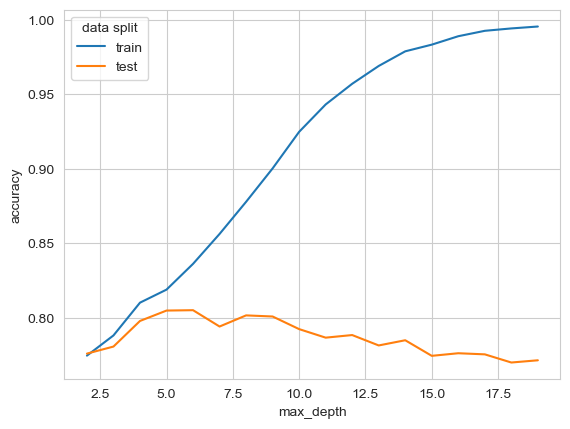

In [133]:
best_accuracy = 0
best_max_depth = -1

to_plot = []
for max_depth_ in range(2,20):
    model = DecisionTreeClassifier(max_depth=max_depth_)
    model.fit(X_train,y_train)
    predictions_train = model.predict(X_train)
    predictions_test = model.predict(X_test)
    to_plot.append([max_depth_,metrics.accuracy_score(y_train,predictions_train),"train"])
    accuracy_test = metrics.accuracy_score(y_test,predictions_test)
    to_plot.append([max_depth_,accuracy_test,"test"])
    if accuracy_test > best_accuracy:
        best_accuracy = accuracy_test
        best_max_depth = max_depth_

print("optimal value for max_depth: {} (accuracy on test set: {:.2f})".format(best_max_depth,best_accuracy))

to_plot = pd.DataFrame(to_plot,columns=["max_depth","accuracy","data split"])

sns.lineplot(data=to_plot,x="max_depth",y="accuracy",hue="data split")
plt.show()

There is a problem with this apporach. We have now used (or seen) the test set to select the best value for `max_depth`, i.e. the value that shows best performance on the test set. This might not be thebest value for truly unseen external data, and we did not evaluate this.

To solve this, yet another part of the data set should be held out (known as the **validation set**). In this case the model is fitted on the training set and the optimal value for `max_depth` is selected using this validation set. A model is then trained on the union of the train and validation set using the best value for `max_depth` and the generalization performance of this model is then computed on the test set. 

However, by partitioning the available data into three sets, we drastically reduce the number of data points used for training the model. Especially for smaller data sets this means that not only the fit of the model (training set) but also the decision on the values of the hyperparameters (validation set) as well as the estimation of the generalization performance (test set) will depend strongly on a particular random choice of the data set splits. 

To make our conclusions less dependent on the random data split we can perform **cross-validation** (CV). In the setup, called **$k$-fold CV**, the data set is randomly split into $k$ disjoint sets of approximately equal size. The following procedure is followed for each of the $k$ “folds” $D_i$ ($i=1 \ldots k$):

1. train a model $m_i$ on the data points in folds $D_j$ with $j \ne i$,
2. use $m_i$ to compute predictions for $D_i.$

As you can see we now have one prediction for each data point such that the model that computed that prediction was fitted on a train set that did not contain that data point. 

The performance measure reported by $k$-fold CV is then computed using these predictions and constitutes a good estimate of the generalization performance of the model. 

By choosing large enough values for $k$ (typical value is 10) the size of the training set becomes larger, while still computing a meaningful prediction for each data point. 

Instead of splitting the training set further into a validation set, we use $k$-fold CV to find the optimal value for `max_depth`:  

In [134]:
from sklearn.model_selection import cross_val_predict

best_accuracy = 0
best_max_depth = -1
for max_depth_ in  range(2,20):
    model = DecisionTreeClassifier(max_depth=max_depth_)
    predictions_cv = cross_val_predict(model, X_train, y_train, method="predict",cv=10)
    accuracy_cv = metrics.accuracy_score(y_train,predictions_cv)
    print("k-fold CV accuracy: {:.2f} (max_depth = {})".format(accuracy_cv,max_depth_))
    if accuracy_cv > best_accuracy:
        best_accuracy = accuracy_cv
        best_max_depth = max_depth_
print("optimal value for max_depth: {}".format(best_max_depth))

k-fold CV accuracy: 0.77 (max_depth = 2)
k-fold CV accuracy: 0.79 (max_depth = 3)
k-fold CV accuracy: 0.80 (max_depth = 4)
k-fold CV accuracy: 0.80 (max_depth = 5)
k-fold CV accuracy: 0.81 (max_depth = 6)
k-fold CV accuracy: 0.81 (max_depth = 7)
k-fold CV accuracy: 0.81 (max_depth = 8)
k-fold CV accuracy: 0.81 (max_depth = 9)
k-fold CV accuracy: 0.81 (max_depth = 10)
k-fold CV accuracy: 0.80 (max_depth = 11)
k-fold CV accuracy: 0.80 (max_depth = 12)
k-fold CV accuracy: 0.80 (max_depth = 13)
k-fold CV accuracy: 0.80 (max_depth = 14)
k-fold CV accuracy: 0.79 (max_depth = 15)
k-fold CV accuracy: 0.79 (max_depth = 16)
k-fold CV accuracy: 0.79 (max_depth = 17)
k-fold CV accuracy: 0.79 (max_depth = 18)
k-fold CV accuracy: 0.79 (max_depth = 19)
optimal value for max_depth: 7


Next, we apply the optimal value for `max_depth` (`best_max_depth`) as obtained during $k$-fold CV to fit a model on the full training set and estimate it's generalization performance on the test set:

In [135]:
model = DecisionTreeClassifier(max_depth=best_max_depth)

model.fit(X_train,y_train)

predictions_train = model.predict(X_train)
print("accuracy on train set: {:.2f}".format(metrics.accuracy_score(y_train,predictions_train)))
predictions_test = model.predict(X_test)
print("accuracy on test set: {:.2f}".format(metrics.accuracy_score(y_test,predictions_test)))

accuracy on train set: 0.86
accuracy on test set: 0.79


Scikit-learn has a method called `GridSearchCV` that implements this procedure more efficiently.

We need to first create Python dictionary the defines the hyperparameters we want to optimize and the values to be consideren. In our case this was hyperparameter `max_depth`:

In [136]:
search_space = {'max_depth': range(2,20)}

Next we can run `GridSearchCV` to evaluate all values using $k$-fold CV:

In [137]:
from sklearn.model_selection import GridSearchCV

model = DecisionTreeClassifier()

grid_search = GridSearchCV(model, param_grid=search_space, cv=10)

grid_search.fit(X_train,y_train)

GridSearchCV(cv=10, estimator=DecisionTreeClassifier(),
             param_grid={'max_depth': range(2, 20)})

Now, the model fitted on the full training set using the optimal value for our hyperparameter can be accessed as follows:

In [138]:
print(grid_search.best_estimator_)
print(grid_search.best_score_)

DecisionTreeClassifier(max_depth=7)
0.809334094993113


We can then use that model to make predictions on unseen external data:

In [139]:
predictions_test = grid_search.best_estimator_.predict(X_test)
print("accuracy on test set: {:.2f}".format(metrics.accuracy_score(y_test,predictions_test)))

accuracy on test set: 0.79


With `GridSearchCV` we can find optimal values for a combination of hyperparameters. Note that all possible combinations will be evaluated, which can take long time.

In [140]:
search_space = {'max_depth': range(2,20),
                'min_samples_split': [2,20,200]}

grid_search = GridSearchCV(model, param_grid=search_space, cv=10)

grid_search.fit(X_train,y_train)

print(grid_search.best_estimator_)
print(grid_search.best_score_)

predictions_test = grid_search.best_estimator_.predict(X_test)
print("accuracy on test set: {:.2f}".format(metrics.accuracy_score(y_test,predictions_test)))

DecisionTreeClassifier(max_depth=7)
0.8097607612949128
accuracy on test set: 0.79


More details about the hyperparameter optimization results can be obtained as follows:

In [141]:
pd.DataFrame(grid_search.cv_results_)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_max_depth,param_min_samples_split,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,split5_test_score,split6_test_score,split7_test_score,split8_test_score,split9_test_score,mean_test_score,std_test_score,rank_test_score
0,0.019226,0.007706,0.001014,0.003042,2,2,"{'max_depth': 2, 'min_samples_split': 2}",0.779082,0.778015,0.769231,0.767094,0.763889,0.778846,0.775641,0.779915,0.780983,0.768162,0.774086,0.005988,52
1,0.018938,0.007507,0.001565,0.004694,2,20,"{'max_depth': 2, 'min_samples_split': 20}",0.779082,0.778015,0.769231,0.767094,0.763889,0.778846,0.775641,0.779915,0.780983,0.768162,0.774086,0.005988,52
2,0.025140,0.008176,0.001562,0.004685,2,200,"{'max_depth': 2, 'min_samples_split': 200}",0.779082,0.778015,0.769231,0.767094,0.763889,0.778846,0.775641,0.779915,0.780983,0.768162,0.774086,0.005988,52
3,0.021985,0.007595,0.004687,0.007160,3,2,"{'max_depth': 3, 'min_samples_split': 2}",0.789755,0.792956,0.784188,0.785256,0.778846,0.792735,0.786325,0.790598,0.792735,0.785256,0.787865,0.004419,48
4,0.022038,0.009959,0.001563,0.004688,3,20,"{'max_depth': 3, 'min_samples_split': 20}",0.789755,0.792956,0.784188,0.785256,0.778846,0.792735,0.786325,0.790598,0.792735,0.785256,0.787865,0.004419,48
5,0.022078,0.007956,0.003117,0.006008,3,200,"{'max_depth': 3, 'min_samples_split': 200}",0.789755,0.792956,0.784188,0.785256,0.778846,0.792735,0.786325,0.790598,0.792735,0.785256,0.787865,0.004419,48
6,0.031778,0.012446,0.006106,0.007493,4,2,"{'max_depth': 4, 'min_samples_split': 2}",0.801494,0.806830,0.798077,0.794872,0.784188,0.805556,0.809829,0.804487,0.817308,0.780983,0.800362,0.010660,29
7,0.030456,0.010989,0.002144,0.005772,4,20,"{'max_depth': 4, 'min_samples_split': 20}",0.801494,0.806830,0.798077,0.794872,0.784188,0.805556,0.809829,0.804487,0.817308,0.780983,0.800362,0.010660,29
8,0.038150,0.009615,0.002418,0.004778,4,200,"{'max_depth': 4, 'min_samples_split': 200}",0.801494,0.806830,0.798077,0.794872,0.784188,0.805556,0.809829,0.804487,0.817308,0.780983,0.800362,0.010660,29
9,0.042550,0.012145,0.000000,0.000000,5,2,"{'max_depth': 5, 'min_samples_split': 2}",0.802561,0.803629,0.818376,0.787393,0.779915,0.813034,0.808761,0.794872,0.813034,0.783120,0.800469,0.012827,28


**Reference**

[1] Pedersen AG, Nielsen H. Proceedings 5th International Conference on Intelligent Systems for Molecular Biology. 1997. Neural network prediction of translation initiation sites in eukaryotes: perspectives for EST and genome analysis; pp. 226–233.